In [50]:
!wget -q -nc https://raw.githubusercontent.com/pseprivamirakbarnejad/cmput206lab/master/Lab5/im1.jpg
!wget -q -nc https://raw.githubusercontent.com/pseprivamirakbarnejad/cmput206lab/master/Lab5/im2.jpg
!ls

im1.jpg  im2.jpg  sample_data


In [51]:
# Import libraries
from skimage import io
from skimage import exposure
import skimage
from skimage.color import rgb2gray
from skimage import transform
import matplotlib.pyplot as plt
import numpy as np

from skimage.feature import (match_descriptors, corner_harris,
                             corner_peaks, ORB, plot_matches)
from skimage.measure import ransac
from skimage.transform import ProjectiveTransform

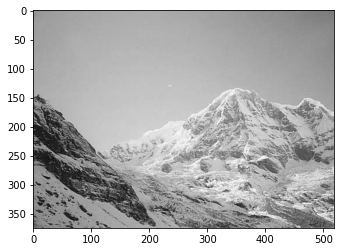

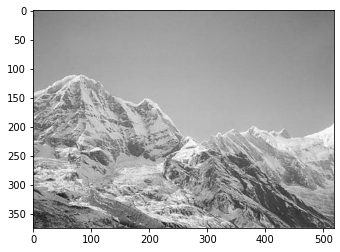

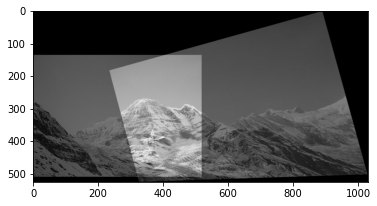

In [52]:

# Bugs
# I used other detectors, they cause crashes except ORB
# There is a lot of bugs encountered in this part, since this part needs me to study some new functions from library
# In ransac function, i messed up with the input parameters, since there is two data sets to be used. I solved this bug 
# by clearly reading the official documentation about this function and some example code others write using this function


# For ploting the final image, i used the normal plot ar the beginning, but it failed to show the final image

# There is a problem with my code that i can not fix. I don't know why every time i execute my code, the output image will be different. 
# Some output are very similar to the required output, some are very different. 
# I though it may be some functions problem like ORB/ransac. I don't think i am able to fix it

# read the two images
image0 = io.imread('im1.jpg', True)
image1 = io.imread('im2.jpg', True)

# plot two images
plt.imshow(image0,cmap='gray')
plt.show()
plt.imshow(image1,cmap='gray')
plt.show()
#Feature detection and matching

# Initiate ORB detector
# ORB is feature function in skimage module. The parameter n_keypoints is the number of keypoints to be returned.
ORB_detector = ORB(n_keypoints=500)


# Find the keypoints and descriptors
# detect_and_extract with parameter of a image is a function that ORB dectector has. It is used to detect oriented fast keypoints and extract rBRIEF descriptors. 
ORB_detector.detect_and_extract(image0)
keypoints1 = ORB_detector.keypoints
descriptors1 = ORB_detector.descriptors
ORB_detector.detect_and_extract(image1)
keypoints2 = ORB_detector.keypoints
descriptors2 = ORB_detector.descriptors

# initialize Brute-Force matcher and exclude outliers. See match descriptor function.
# The match descriptor function given here is to find the closest descriptor in the second set for each descriptor in the first set this matcher  (and vice-versa in the case of enabled cross-checking).
# It takes descriptors1, descriptors2 as main parameters. max_distance as its restriction to seek for the closest descripters in another set of descriptor.  cross_check is true, so it will return matched pairs
# citation https://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.match_descriptors
match =  match_descriptors(descriptors1,descriptors2, max_distance = 10,cross_check=True)
#print(match)

# Compute homography matrix using ransac and ProjectiveTransform
# model_robust, inliers = ransac ...
# https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.ransac
# the robust estimation of parameters from a subset of inliers from the complete data set. 
# parameter1: the data sets the model is fitted. since this is multiple data sets, it can be passed with tuple
# parameter2: transform methods 'ProjectiveTrans' as requested. There could be other transform like AffinTrans
# parameter3: min_samples: The minimum number of data points to fit a model to.
# parameter4: residual_threshold: Maximum distance for a data point to be classified as an inlier. 
data1 = keypoints1[match[:,0]][:,::-1]
data2 = keypoints2[match[:,1]][:,::-1]
model_robust, inliers = ransac((data2,data1), ProjectiveTransform, min_samples=3, residual_threshold=2)


#Warping
#Next, we produce the panorama itself. The first step is to find the shape of the output image by considering the extents of all warped images.

r, c = image1.shape[:2]

# Note that transformations take coordinates in
# (x, y) format, not (row, column), in order to be
# consistent with most literature.
corners = np.array([[0, 0],
                    [0, r],
                    [c, 0],
                    [c, r]])

# Warp the image corners to their new positions.
warped_corners = model_robust(corners)

# Find the extents of both the reference image and
# the warped target image.
all_corners = np.vstack((warped_corners, corners))

corner_min = np.min(all_corners, axis=0)
corner_max = np.max(all_corners, axis=0)

output_shape = (corner_max - corner_min)
output_shape = np.ceil(output_shape[::-1])

#The images are now warped according to the estimated transformation model.

#A shift is added to ensure that both images are visible in their entirety. Note that warp takes the inverse mapping as input.

from skimage.exposure import rescale_intensity
from skimage.transform import warp
from skimage.transform import SimilarityTransform
from skimage.color import gray2rgb

offset = SimilarityTransform(translation=-corner_min)

image0_ = warp(image0, offset.inverse,
               output_shape=output_shape)

image1_ = warp(image1, (model_robust + offset).inverse,
               output_shape=output_shape)

#An alpha channel is added to the warped images before merging them into a single image:

def add_alpha(image, background=-1):
    """Add an alpha layer to the image.

    The alpha layer is set to 1 for foreground
    and 0 for background.
    """

    rgb = gray2rgb(image)
    alpha = (image != background)
    return np.dstack((rgb, alpha))


#add alpha to the image0 and image1
img0 = add_alpha(image0_)
img1 = add_alpha(image1_)

#your code
#merge the alpha added image
merged = (img0+img1)
#your code
#merged = ...

alpha = merged[..., 3]
merged /= np.maximum(alpha, 1)[..., np.newaxis]
# The summed alpha layers give us an indication of
# how many images were combined to make up each
# pixel.  Divide by the number of images to get
# an average.


#show and save the output image as '/content/gdrive/My Drive/CMPUT 206 Wi19/Lab5_Files/imgOut.png'
fig, ax = plt.subplots()
ax.imshow(merged,'gray')
plt.show()


#io.imsave("/content/gdrive/My Drive/CMPUT 206 Wi19/Lab5_Files/imgOut.png",merged)